In [27]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from io_functions import *
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
#from grids import *
from docking_analysis import *

In [28]:
import io_functions
from imp import reload
reload(io_functions)
from io_functions import *

In [29]:
from operator import itemgetter

In [30]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In this iPython notebook, we will featurize MOR ligand binding simulation by pairwise distances between the ligand and different receptor residues. We will then perform tICA and prospectively build an MSM. 

In [31]:
from detect_intermediates import *
from interpret_tICs import *

In [32]:
from mor_h8_feature_types import *
from get_variable_names import *
from mor_h8_tica_config import *
from residue import Residue, Atom
ori_feature_name = copy.deepcopy(feature_name)

In [33]:
rho = 0.1
rho_string = "0pt1"
lag_time = 5
n_components = 5
n_clusters = 1500

rho = 0.1
rho_string = "0pt1"
lag_time=50
ori_feature_name = copy.deepcopy(feature_name)

In [34]:
schemes = ["closest-heavy", "CA"]
feature_name = "%s-CA-py3" %ori_feature_name
#feature_name = "%s_phi_psi_chi2" %feature_name
(active_ref_dir, inactive_ref_dir, simulation_ref_dir, scripts_dir,
          ligand_dir, agonist_dir, inverse_agonist_dir, biased_agonist_dir, ref_receptors_dir, whole_trajectory_pnas,
          sasa_file) = get_base_files(base)

tica_dir = get_tica_dir(base, is_sparse, lag_time, n_components, feature_name, 
                                 wolf_string, shrinkage_string, rho_string)
#tica_dir = "%s-with-inactive" %tica_dir
tica_dir = "%s-backup" %tica_dir
ori_tica_dir = copy.deepcopy(tica_dir)
#tica_dir = "%s-normalized" % ori_tica_dir
features_dir = get_features_dir(base, feature_name)

landmarks_dir = get_landmarks_dir(tica_dir)
analysis_dir = get_analysis_dir(tica_dir, n_clusters, sampling_method)
gmm_dir = get_gmm_dir(tica_dir)
rf_dir = get_rf_dir(tica_dir)


ref_tica_dir, ref_tica_coords = get_ref_tica_dirs(tica_dir)

graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)

pnas_titles =  ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]
pnas_features_dir = analysis_dir


(clusterer_dir, msm_model_dir, macrostate_dir, features_known, model_dir, projected_features_dir,
         projection_operator_dir, ktica_fit_model_filename, ktica_projected_data_filename, nystroem_data_filename,
         mutual_information_csv, pearson_csv) = get_tica_files(base, tica_dir, n_clusters, msm_lag_time, n_macrostates)

(standardized_features_dir, feature_residues_csv, feature_residues_pkl,
          contact_csv, ref_features_dir) = get_feature_files(features_dir)

(kmeans_csv, tica_coords_csv, features_csv, active_rmsd_dir, inactive_rmsd_dir, active_pnas_dir, inactive_pnas_joined, active_pnas_joined,
        clusters_map_file, ktica_clusters_map_file, analysis_file, combined_file, docking_summary, docking_joined, docking_z_scores_csv,
        aggregate_docking, aggregate_docking_joined, docking_pnas_joined, aggregate_docking_pnas, aggregate_docking_pnas_joined, docking_multiple_ligands,
        docking_distances_file, docking_pdf, mmgbsa_docking_distances, pnas_coords, mmgbsa_dir, mmgbsa_csv, mmgbsa_pdf, aggregate_mmgbsa,
        aggregate_mmgbsa_joined, aggregate_mmgbsa_pnas_joined, mmgbsa_z_scores_csv, active_clusters_csv, intermediate_clusters_csv,
        inactive_clusters_csv, pnas_clusters_averages, tica_clusters_averages, tica_classes_csv, tica_samples_csv, subgraph_save_base,
        degree_save_base, degree_map_csv, degree_z_map_csv, aggregate_docking_pnas_degree_z_joined, tic_residue_csv, feature_coefs_csv,
        duplicated_feature_coefs_csv) = get_analysis_files(analysis_dir, n_clusters, tica_dir, tica_dir, sampling_method, n_samples, precision,
                                                           msm_lag_time)

(inactive_pnas_distances_dir, active_pnas_distances_dir, active_pnas_all_distances_dir,
          inactive_pnas_distances_new_csv, active_pnas_distances_new_csv, active_pnas_joined, active_pnas_means, pnas_coords_dir,
          pnas_coords_csv, pnas_all_coords_csv, pnas_coords_hexbin_dir, pnas_coords_co_crystallized_docking_dir,
          pnas_coords_active_colors_dir, user_defined_features_file, reaction_coordinates_trajs_file) = get_pnas_files(whole_trajectory_pnas, pnas_features_dir)

features_dir = get_features_dir(base, feature_name)



graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)
(scripts_dir, pymol_fixpdb_dir) = get_script_dir(scripts_dir)
(save_dir, reimaged_dir, mae_dir, combined_reimaged_dir, grid_dir, docking_dir) = get_docking_dirs(tica_dir, n_clusters, n_components, n_samples, sampling_method, precision)


/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3
/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3


In [19]:
features_dir

'/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3'

In [10]:
from ipyparallel import Client
rc = Client()
print(len(rc.ids))
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))

144


<AsyncMapResult: chdir>

In [ ]:
import custom_featurizer
reload (custom_featurizer)
from custom_featurizer import *
suf_trajectories = [t for t in get_trajectory_files(traj_dir, ".h5") if "suf" in t and "re" in t]
fix_chain_names(suf_trajectories, dview)
#featurize_contacts_custom(traj_dir, features_dir = features_dir, traj_ext = traj_ext, contact_residue_pairs_file = feature_residues_pkl, structures=[inactive_dir, active_dir], contact_residues=contact_residues,
#                          residues_map = None, contact_cutoff = cutoff, parallel = False, exacycle = exacycle, traj_top_structure = None, iterative=False,
#                          user_specified_atom_residue_pairs = [], load_from_file=False, worker_pool=None, schemes=schemes)

In [ ]:
user_defined_features_dir = "%s/user_defined_features" %traj_dir
if not os.path.exists(user_defined_features_dir):
    os.makedirs(user_defined_features_dir)
compute_user_defined_features_wrapper(traj_dir, traj_ext, inactive_dir, active_dir, None,
                                        feature_name_residues_dict, user_defined_features_file, worker_pool=dview, 
                                        save_dir=user_defined_features_dir, parallel=False, overwrite=True)

In [ ]:
ref_user_defined_features_file = "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5"
ref_user_defined_features_dir = "%s/ref_user_defined_features" %traj_dir
if not os.path.exists(ref_user_defined_features_dir):
    os.makedirs(ref_user_defined_features_dir)

compute_user_defined_features_wrapper(ref_receptors_dir, ".pdb", inactive_dir, active_dir, None,
                                        feature_name_residues_dict, ref_user_defined_features_file, worker_pool=None, 
                                        save_dir=ref_user_defined_features_dir, parallel=False, overwrite=True)

In [11]:
traj_dir = "/home/enf/md_simulations/MOR/h8_reimaged/trajectories"

In [ ]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
featurize_contacts_custom(traj_dir, features_dir = features_dir, traj_ext = traj_ext, contact_residue_pairs_file = feature_residues_pkl, structures=[inactive_dir, active_dir], contact_residues=contact_residues,
                          residues_map = None, contact_cutoff = cutoff, parallel = False, exacycle = exacycle, traj_top_structure = None, iterative=False,
                          user_specified_atom_residue_pairs = [], load_from_file=False, worker_pool=dview, schemes=schemes, binarize=None, redo=True, within_turn=False)

In [14]:
fit_normalizer(features_dir)

loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/apo_rep_1.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/apo_rep_10.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/apo_rep_100.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/apo_rep_101.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/apo_rep_102.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/apo_rep_103.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/apo_rep_104.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/apo_rep_105.dat

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



KeyboardInterrupt: 

In [39]:
import pickle
with open(feature_residues_pkl, "rb") as f:
    feature_residues = pickle.load(f)

In [40]:
"three" > "four"

True

In [35]:
import custom_tica
reload(custom_tica)
from custom_tica import *
fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext, normalize=True, partial_fit=True)

loading "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3/normalizer.h5"...
loading feature files
fitting tICA model to /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3/apo_rep_1.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3/apo_rep_1.dataset
fitting tICA model to /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3/apo_rep_10.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3/apo_rep_10.dataset
fitting tICA model to /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3/apo_rep_100.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3/apo_rep_100.dataset
fitting tICA model to /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_

In [ ]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *

featurize_contacts_custom(ref_receptors_dir, features_dir = ref_features_dir, traj_ext = ".pdb", contact_residue_pairs_file = feature_residues_pkl, structures=[inactive_dir, active_dir], contact_residues=contact_residues,
                          residues_map = None, contact_cutoff = cutoff, parallel = False, exacycle = exacycle, traj_top_structure = None, iterative=False,
                          user_specified_atom_residue_pairs = [], load_from_file=False, worker_pool=None, schemes=schemes, within_turn=False, binarize=None, redo=True)

In [88]:
transform(existing_model = projection_operator_dir, features_directory = ref_features_dir, tica_dir = ref_tica_dir, normalizer=compat_verboseload("%s/normalizer.h5" %features_dir))


loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/phi_psi_chi2_allprot_tica_coords.h5"...
None
None
['/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors/4dkl_R_for_conformation.dataset', '/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors/5c1m.dataset']
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors/5c1m.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors/4dkl_R_for_conformation.dataset


In [ ]:
import custom_tica
reload(custom_tica)
from custom_tica import *
transform_to_h5(projection_operator_dir, features_dir, projected_features_dir, worker_pool=None, parallel=True, normalizer=compat_verboseload("%s/normalizer.h5" %features_dir))

In [21]:
tica_object = compat_verboseload(projection_operator_dir)

In [22]:
with open(projection_operator_dir, 'rb') as f:
    tica_object = pickle.load(f, encoding='latin1') 

In [23]:
#all_tica = compat_verboseload(projected_features_dir)
#all_tica = [x[:,range(1,10)] for x in all_tica]
#print(all_tica[0].shape)
#print(len(all_tica))
#verbosedump(all_tica, projected_features_dir)


In [24]:
#n_components=9

In [25]:
tica_object.timescales_

array([ 2764.5450165 ,   970.15495783,   867.97135407,   494.70416018,
         413.70152939])

In [ ]:
plot_columns(tica_dir, projected_features_dir, titles = ["tIC%d" %j for j in range(1,11)], tICA = True, scale = 1.0, refcoords_file = None)

In [44]:
feature_indices = []
traj_basenames = get_trajectory_files(traj_dir, ".h5")
traj_basenames = [os.path.splitext(os.path.basename(t))[0] for t in traj_basenames]
feature_basenames = get_trajectory_files(features_dir, ".dataset")
feature_basenames = [os.path.splitext(os.path.basename(t))[0] for t in feature_basenames]
for i, traj_basename in enumerate(traj_basenames):
    if traj_basename in feature_basenames:
        feature_indices.append(int(i))

In [45]:
tica_coords = compat_verboseload(projected_features_dir)
pnas_coords = compat_verboseload(user_defined_features_file)
pnas_coords = [pnas_coords[i] for i in feature_indices]
tica_names = ["tIC.%d" %i for i in range(1,n_components+1)]
pnas_names = sorted(feature_name_residues_dict.keys())

In [46]:
print(np.concatenate(tica_coords).shape)
print(np.concatenate(pnas_coords).shape)

(755979, 5)
(755979, 15)


In [ ]:
from plots import *

In [ ]:
plot_data_vs_data(np.concatenate(tica_coords), np.concatenate(pnas_coords), tica_names, pnas_names, analysis_dir)

In [47]:
subsampled_features_dir = os.path.join(tica_dir, "subsampled_features")
if not os.path.exists(subsampled_features_dir): os.makedirs(subsampled_features_dir)

In [48]:
feature_names = compat_verboseload(feature_residues_pkl)

In [49]:
ref_features = [load_file(f) for f in get_trajectory_files(ref_features_dir, ".dataset")]
print(len(ref_features))
print(ref_features[0].shape)
print(ref_features[1].shape)
print(len(feature_names))
ref_features = pd.DataFrame(ref_features[0], columns=[str(f) for f in feature_names])

loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors/4dkl_R_for_conformation.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors/5c1m.dataset
2
(1, 2408)
(1, 2408)
2408


In [26]:
#import interpret_tICs
#reload(interpret_tICs)
#from interpret_tICs import *
tic_components_dir = tica_dir
important_contact_features = interpret_tIC_components(projection_operator_dir, tic_components_dir, feature_residues_pkl, n_tica_components=n_components, percentile=95)


Interpreting tIC 1
feature_importances_df.shape
(5, 5)
residue_importances_df.shape
(6, 2)
             feature_name      res_i      res_j  importance  \
2  Ala304_Ca To Tyr299_Ca  Ala304_Ca  Tyr299_Ca   -0.536415   
1  Ala304_Ca To Ile301_Ca  Ala304_Ca  Ile301_Ca    0.433491   
0        Ile301 To Leu305     Ile301     Leu305    0.259899   
4  Lys303_Ca To Tyr299_Ca  Lys303_Ca  Tyr299_Ca    0.186675   
3  Ile301_Ca To Lys303_Ca  Ile301_Ca  Lys303_Ca   -0.126602   

                  feature  
2  ALA304_CA to TYR299_CA  
1  ALA304_CA to ILE301_CA  
0        ILE301 to LEU305  
4  LYS303_CA to TYR299_CA  
3  ILE301_CA to LYS303_CA  
Using dark_background
             residue  importance
Ile301_Ca  Ile301_Ca    0.405487
Ala304_Ca  Ala304_Ca    0.384996
Leu305        Leu305    0.259899
Ile301        Ile301    0.259899
Lys303_Ca  Lys303_Ca    0.171012
Tyr299_Ca  Tyr299_Ca    0.150521
Using dark_background
Interpreting tIC 2
feature_importances_df.shape
(6, 5)
residue_importances_df.shape
(6,

In [51]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
tic_subsampled_features_file = "%s/features_subsampled.pkl" % tica_dir
subsampled_features_dir = os.path.join(tica_dir, "subsampled_features")
if not os.path.exists(subsampled_features_dir): os.makedirs(subsampled_features_dir)
important_contact_features_pruned, important_contact_features_indices = find_non_zero_features(important_contact_features[0], feature_names)
if not os.path.exists(tic_subsampled_features_file):
    subsample_features(features_dir, important_contact_features_indices, important_contact_features_pruned, tic_subsampled_features_file)

In [52]:
tic_subsampled_features_file

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/features_subsampled.pkl'

In [53]:
protein_top_features = load_file(tic_subsampled_features_file)
protein_top_features_concat = pd.concat(protein_top_features)

loading /home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/features_subsampled.pkl


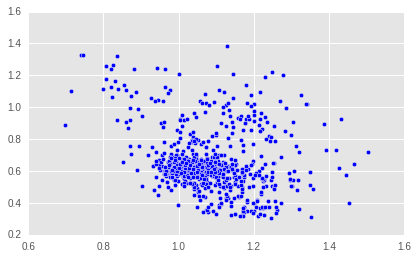

In [178]:
plt.scatter(protein_top_features_concat["LEU158_CA to VAL285_CA"].values[::1000], protein_top_features_concat["PHE289 to TYR336"].values[::1000])
plt.show()

In [ ]:
from ipyparallel import Client
rc = Client()
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))

print(len(rc.ids))


In [54]:
bu72_trajs = []
apo_trajs = []
oxy_trajs = []
suf_trajs = []
trv_trajs = []
trajs = get_trajectory_files(features_dir, ".dataset")
#trajs = [t for t in get_trajectory_files(traj_dir, traj_ext) if "apo_reimaged" not in t and "oxy" not in t]
for i, traj in enumerate(trajs):
    if "bu72" in traj or "CO" in traj or "Co" in traj:
        bu72_trajs.append(i)
    elif "apo" in traj:
        apo_trajs.append(i)
    elif "oxy" in traj:
        oxy_trajs.append(i)
    elif "suf" in traj:
        suf_trajs.append(i)
    elif "trv" in traj:
        trv_trajs.append(i)

user_defined_coords = load_file(user_defined_features_file)

            

loading /home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/user_defined_features.h5


In [55]:
len(bu72_trajs)

512

In [56]:
bu72_pnas = [user_defined_coords[i] for i in bu72_trajs]
apo_pnas = [user_defined_coords[i] for i in apo_trajs]
oxy_pnas = [user_defined_coords[i] for i in oxy_trajs]
suf_pnas = [user_defined_coords[i] for i in suf_trajs]

In [57]:
bu72_pnas_file = "%s/bu72.h5" % whole_trajectory_pnas
apo_pnas_file = "%s/apo.h5" % whole_trajectory_pnas
#oxy_pnas_file = "%s/oxy.h5" % whole_trajectory_pnas
suf_pnas_file = "%s/suf.h5" % whole_trajectory_pnas

In [58]:
from imp import reload
import analysis
reload(analysis)
from analysis import *
import seaborn as sns
bu72_pnas_concatenated = np.concatenate(bu72_pnas)
print(np.shape(bu72_pnas_concatenated))
apo_pnas_concatenated = np.concatenate(apo_pnas)
#oxy_pnas_concatenated = np.concatenate(oxy_pnas)
suf_pnas_concatenated = np.concatenate(suf_pnas)




verbosedump(bu72_pnas, bu72_pnas_file)
verbosedump(apo_pnas, apo_pnas_file)
#verbosedump(oxy_pnas, oxy_pnas_file)
verbosedump(suf_pnas, suf_pnas_file)





columns=sorted(feature_name_residues_dict.keys())
#plot_columns(whole_trajectory_pnas, bu72_pnas_file, titles=columns, main = "BU72", tICA = False, scale = 1.0, refcoords_file = None)
#plot_columns(whole_trajectory_pnas, apo_pnas_file, titles=columns, main = "Apo", tICA = False, scale = 1.0, refcoords_file = None)

#df = pd.DataFrame(bu72_pnas_concatenated, columns=sorted(feature_name_residues_dict.keys()))
#sns.jointplot(x="tm6_tm3_dist", y="rmsd_npxxy_inactive", data=df, kind="kde")
#plt.hexbin(bu72_pnas_concatenated[:,0], bu72_pnas_concatenated[:,2], cmap=plt.cm.YlOrRd_r)

(248499, 15)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/bu72.h5"... (<class 'list'>)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/apo.h5"... (<class 'list'>)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/suf.h5"... (<class 'list'>)


In [59]:
#oxy_tica_file = "%s/oxy_tica.h5" % tica_dir
bu72_tica_file = "%s/bu72_tica.h5" % tica_dir
apo_tica_file = "%s/apo_tica.h5" % tica_dir
suf_tica_file = "%s/suf_tica.h5" % tica_dir

In [60]:
tica_coords = compat_verboseload(projected_features_dir)
#oxy_tica = [tica_coords[i] for i in oxy_trajs]
bu72_tica = [tica_coords[i] for i in bu72_trajs]
apo_tica = [tica_coords[i] for i in apo_trajs]
suf_tica = [tica_coords[i] for i in suf_trajs]


#verbosedump(oxy_tica, oxy_tica_file)
verbosedump(bu72_tica, bu72_tica_file)
verbosedump(apo_tica, apo_tica_file)
verbosedump(suf_tica, suf_tica_file)



columns = ["tIC%d" %i for i in range(1,n_components+1)]
#plot_columns(tica_dir, bu72_tica_file, titles=columns, main = "BU72", tICA = False, scale = 1.0, refcoords_file = None)
#plot_columns(tica_dir, apo_tica_file, titles=columns, main = "Apo", tICA = False, scale = 1.0, refcoords_file = None)




Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_tica.h5"... (<class 'list'>)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_tica.h5"... (<class 'list'>)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_tica.h5"... (<class 'list'>)


In [61]:
#print(np.concatenate(oxy_tica).shape)
print(np.concatenate(apo_tica).shape)
print(np.concatenate(bu72_tica).shape)
print(np.concatenate(suf_tica).shape)


(235459, 5)
(248499, 5)
(272021, 5)


In [70]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *
n_clusters = 500
clusterer_dir = "%s/clusterer_%dclusters.h5" %(tica_dir, n_clusters)
if not os.path.exists(clusterer_dir):
    cluster_minikmeans(tica_dir, projected_features_dir, traj_dir, n_clusters=n_clusters, clusterer_dir=clusterer_dir)

In [71]:
print(clusterer_dir)

/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/clusterer_500clusters.h5


In [72]:
oxy_clusterer_file = "%s/oxy_clusterer%d.h5" %(tica_dir, n_clusters)
bu72_clusterer_file = "%s/bu72_clusterer%d.h5" %(tica_dir, n_clusters)
apo_clusterer_file = "%s/apo_clusterer%d.h5" %(tica_dir, n_clusters)
suf_clusterer_file = "%s/suf_clusterer%d.h5" %(tica_dir, n_clusters)



In [73]:
clusterer = compat_verboseload(clusterer_dir)
cluster_labels = clusterer.labels_
#oxy_clusters = [cluster_labels[i] for i in oxy_trajs]
bu72_clusters = [cluster_labels[i] for i in bu72_trajs]
apo_clusters = [cluster_labels[i] for i in apo_trajs]
suf_clusters = [cluster_labels[i] for i in suf_trajs]



bu72_clusterer = copy.deepcopy(clusterer)
bu72_clusterer.labels_ = bu72_clusters
#if not os.path.exists(bu72_clusterer_file):
verbosedump(bu72_clusterer, bu72_clusterer_file)

apo_clusterer = copy.deepcopy(clusterer)
apo_clusterer.labels_ = apo_clusters
    
#if not os.path.exists(apo_clusterer_file):
verbosedump(apo_clusterer, apo_clusterer_file)

#oxy_clusterer = copy.deepcopy(clusterer)
#oxy_clusterer.labels_ = oxy_clusters
    
#if not os.path.exists(oxy_clusterer_file):
#verbosedump(oxy_clusterer, oxy_clusterer_file)

suf_clusterer = copy.deepcopy(clusterer)
suf_clusterer.labels_ = suf_clusters
    
#if not os.path.exists(oxy_clusterer_file):
verbosedump(suf_clusterer, suf_clusterer_file)

Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_clusterer500.h5"... (<class 'msmbuilder.cluster.MiniBatchKMeans'>)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_clusterer500.h5"... (<class 'msmbuilder.cluster.MiniBatchKMeans'>)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_clusterer500.h5"... (<class 'msmbuilder.cluster.MiniBatchKMeans'>)


In [66]:
cluster_tica_averages = calculate_cluster_averages_per_feature(bu72_clusterer, bu72_tica)
cluster_tica_averages = pd.DataFrame(cluster_tica_averages, columns=["tIC.%d" %i for i in range(1, n_components+1)])



In [83]:
intermediate_actives = cluster_tica_averages.loc[(cluster_tica_averages["tIC.2"] > 0.7) & (cluster_tica_averages["tIC.2"] < 1.2) & (cluster_tica_averages["tIC.5"] > 0.) & (cluster_tica_averages["tIC.2"] < 0.8)]
intermediate_actives

,tIC.1,tIC.2,tIC.3,tIC.4,tIC.5


In [ ]:
import custom_msm
reload(custom_msm)
from custom_msm import *
from msm_resampled import *

In [74]:
apo_clusters_map = make_clusters_map(apo_clusterer)
bu72_clusters_map = make_clusters_map(bu72_clusterer)
#oxy_clusters_map = make_clusters_map(oxy_clusterer)
suf_clusters_map = make_clusters_map(suf_clusterer)

5
11
0
400
400
2
23
644
307
5
218
419
907
6
2
1207
226
899
0
1917
304
720
455
32
1156
0
126
2
106
349
839
0
0
4
528
937
683
0
0
2227
8
1716
2
1266
0
1100
851
0
1187
0
0
620
1
1
354
90
19
5
2280
441
0
0
1249
1
284
0
1670
757
256
1880
0
0
228
0
1243
8
981
123
1164
106
780
0
566
1032
154
584
769
439
16
0
0
0
1450
0
0
648
0
0
0
0
2645
348
564
682
807
362
0
1644
0
528
4
1471
2
0
181
248
1064
6
434
1085
1524
392
743
1
120
1516
23
115
75
1788
0
0
7
0
687
11
39
0
671
578
111
540
2
864
249
730
53
712
624
0
73
513
0
503
129
8
57
618
134
1279
2
0
0
276
1017
1
949
819
0
1702
243
0
525
2122
1552
56
920
2
0
714
0
2
476
48
197
1372
2803
0
1005
444
0
0
0
1774
60
197
0
270
761
121
1773
7
37
0
0
403
126
195
475
544
825
0
1294
387
43
306
595
1990
4
0
544
30
1170
1004
22
801
332
565
3
1949
186
0
18
61
0
1256
0
967
313
852
654
0
1226
4
4
103
169
2243
0
0
548
3
0
67
573
1518
248
4
404
1168
433
0
5
0
156
1
692
98
1
597
623
0
569
505
1431
2630
24
550
436
330
512
434
278
0
0
2
19
1410
54
453
912
996
1576
426
4

In [79]:
import custom_msm
reload(custom_msm)
from custom_msm import *
plt.clf()
plot_timescales(apo_clusterer_file, n_clusters, tica_dir, main="Apo MSM Timescales", lag_times=list(range(1,51,10)))

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_clusterer500.h5"...
MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=500, n_init=10, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=0)
MSM contains 3 strongly connected components above weight=1.00. Component 2 selected, with population 99.815277%
MSM contains 3 strongly connected components above weight=0.09. Component 2 selected, with population 99.812903%
MSM contains 6 strongly connected components above weight=0.05. Component 3 selected, with population 99.812200%
MSM contains 10 strongly connected components above weight=0.03. Component 6 selected, with population 99.810098%
MSM contains 15 strongly connected components above weight=0.02. Component 11 selected, with population 99.806

In [80]:
plt.clf()
plot_timescales(bu72_clusterer_file, n_clusters, tica_dir, main="BU72 MSM Timescales", lag_times=list(range(1,51,10)))

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_clusterer500.h5"...
MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=500, n_init=10, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=0)
MSM contains 2 strongly connected components above weight=1.00. Component 1 selected, with population 99.999597%
MSM contains 4 strongly connected components above weight=0.09. Component 3 selected, with population 96.214389%
MSM contains 6 strongly connected components above weight=0.05. Component 3 selected, with population 96.200162%
MSM contains 6 strongly connected components above weight=0.03. Component 3 selected, with population 96.185555%
MSM contains 6 strongly connected components above weight=0.02. Component 3 selected, with population 96.17120

In [69]:
plt.clf()
plot_timescales(suf_clusterer_file, n_clusters, tica_dir, main="SUF MSM Timescales", lag_times=list(range(1,101,25)))

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_clusterer500.h5"...
MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=500, n_init=10, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=0)
MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.04. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.02. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.01. Component 0 selected, with population 100.000000%
[[  1.84360971e+03   1.36255902e+02   1.10274956e+02   7.60115219e+01
    4.65986337e+01]
 [  4.72928439e+04   

In [85]:
apo_lag_time=50.
prior_counts = 0.0
apo_msm_dir = os.path.join(tica_dir, "apo_msm_lag-time%d_prior-counts%s_clusters%d.h5" %(apo_lag_time, str(prior_counts), n_clusters))
if not os.path.exists(apo_msm_dir):
    apo_msm = build_msm(apo_clusterer_file, apo_lag_time, apo_msm_dir, prior_counts)
else:
    apo_msm = compat_verboseload(apo_msm_dir)

import msm_resampled
reload(msm_resampled)
from msm_resampled import *
total_samples = 20000
num_trajs = len(apo_trajs)
prior_counts = 0.
apo_resampled_traj_to_frames_file = os.path.join(tica_dir, "apo_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(apo_lag_time, str(prior_counts), n_clusters, total_samples))
#if not os.path.exists(apo_resampled_traj_to_frames_file):
apo_resampled_traj_to_frames = resample_by_msm(total_samples, apo_msm, apo_clusters_map, num_trajs, apo_resampled_traj_to_frames_file)
#else:
apo_resampled_traj_to_frames = compat_verboseload(apo_resampled_traj_to_frames_file)

apo_pnas = compat_verboseload(apo_pnas_file)
apo_pnas_resampled_file = os.path.join(tica_dir, "apo_pnas_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(apo_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(apo_pnas, apo_resampled_traj_to_frames, apo_pnas_resampled_file)
apo_pnas_resampled = compat_verboseload(apo_pnas_resampled_file)

tica_concatenated = np.concatenate(compat_verboseload(projected_features_dir))
tica_axes = [(np.min(tica_concatenated[:,i]), np.max(tica_concatenated[:,i])) for i in range(0, np.shape(tica_concatenated)[1])]

apo_tica = compat_verboseload(apo_tica_file)
apo_tica_resampled_file = os.path.join(tica_dir, "apo_tica_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(apo_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(apo_tica, apo_resampled_traj_to_frames, apo_tica_resampled_file)
apo_tica_resampled = compat_verboseload(apo_tica_resampled_file)

apo_clusterer = compat_verboseload(apo_clusterer_file)
apo_msm = compat_verboseload(apo_msm_dir)

cluster_id_proportion_tuples = []

equilibrium_populations = apo_msm.populations_

for cluster_id in apo_msm.mapping_.keys():
    state_id = apo_msm.mapping_[cluster_id]
    cluster_id_proportion_tuples.append((cluster_id,equilibrium_populations[state_id]))
cluster_id_proportion_tuples = sorted(cluster_id_proportion_tuples, key=itemgetter(1), reverse=True)

#plot_all_tics_and_clusters(tica_dir, apo_tica_resampled_file, apo_clusterer_file, lag_time, tic_range=range(0,n_components), main = "Apo_MSM_Reweighted", label = "cluster_id", active_cluster_ids = [c[0] for c in cluster_id_proportion_tuples[0:100]], intermediate_cluster_ids = [], inactive_cluster_ids = [], concatenate=False, axes=tica_axes)

#plot_columns(tica_dir, apo_tica_resampled_file, titles = ["tIC.%d" %i for i in range(1,n_components+1)], main = "mOR_Apo_MSM_", tICA = False, scale = 1.0, refcoords_file = ref_tica_coords, axes=tica_axes, concatenate=False, reshape=False)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_clusterer250.h5"...
fitting msm to trajectories with 250 clusters and lag_time 50
MSM contains 13 strongly connected components above weight=0.02. Component 8 selected, with population 99.810825%
MarkovStateModel(ergodic_cutoff='on', lag_time=50.0, n_timescales=None,
         prior_counts=0.0, reversible_type='mle', sliding_window=True,
         verbose=True)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_msm_lag-time50_prior-counts0.0_clusters250.h5"... (<class 'msmbuilder.msm.msm.MarkovStateModel'>)
fitted msm to trajectories with 199 states
Found number to sample per cluster based on equilibrium proporrtions.
Obtained random (trajectory, frame) pairs based on equilibrium populatio

In [ ]:
print(np.concatenate(suf_tica).shape)
print(np.concatenate(suf_pnas).shape)

In [ ]:
sorted(feature_name_residues_dict.keys())

In [ ]:
plt.hexbin(apo_tica_resampled[:,2], apo_tica_resampled[:,9])
plt.show()

In [ ]:
apo_tica_resampled.shape

In [ ]:
plt.scatter(bu72_tica_resampled[:,2], bu72_tica_resampled[:,9])
plt.show()

In [ ]:
bu72_msm.timescales_

In [ ]:
plt.clf()
plt.hist(np.concatenate(apo_pnas)[:,4], bins=50, range=[0,2])
plt.show()

In [ ]:
plt.clf()
plt.hist(bu72_pnas_resampled[:,8],bins=50, range=[8,16])
plt.show()

In [ ]:
plt.clf()
plt.hist(apo_pnas_resampled[:,8],bins=50, range=[8,16])
plt.show()

In [ ]:
plt.clf()
plt.hist(suf_pnas_resampled[:,8],bins=50, range=[8,16])
plt.show()

In [ ]:
plt.clf()
plt.hist(bu72_tica_resampled[:,2],bins=50, range=[-4,6])
plt.show()

In [ ]:
plt.clf()
plt.hist(apo_tica_resampled[:,2],bins=50, range=[-4,6])
plt.show()

In [86]:

bu72_lag_time=50
prior_counts = 0.
bu72_msm_dir = os.path.join(tica_dir, "bu72_msm_lag-time%d_prior-counts%s_clusters%d.h5" %(bu72_lag_time, str(prior_counts), n_clusters))
if not os.path.exists(bu72_msm_dir):
    bu72_msm = build_msm(bu72_clusterer_file, bu72_lag_time, bu72_msm_dir, prior_counts)
else:
    bu72_msm = compat_verboseload(bu72_msm_dir)

import msm_resampled
reload(msm_resampled)
from msm_resampled import *
total_samples = 20000
num_trajs = len(bu72_trajs)
bu72_resampled_traj_to_frames_file = os.path.join(tica_dir, "bu72_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(bu72_lag_time, str(prior_counts), n_clusters, total_samples))
#if not os.path.exists(bu72_resampled_traj_to_frames_file):
bu72_resampled_traj_to_frames = resample_by_msm(total_samples, bu72_msm, bu72_clusters_map, num_trajs, bu72_resampled_traj_to_frames_file)
#else:
bu72_resampled_traj_to_frames = compat_verboseload(bu72_resampled_traj_to_frames_file)

bu72_pnas = compat_verboseload(bu72_pnas_file)
bu72_pnas_resampled_file = os.path.join(tica_dir, "bu72_pnas_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(bu72_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(bu72_pnas, bu72_resampled_traj_to_frames, bu72_pnas_resampled_file)
bu72_pnas_resampled = compat_verboseload(bu72_pnas_resampled_file)

tica_concatenated = np.concatenate(compat_verboseload(projected_features_dir))
tica_axes = [(np.min(tica_concatenated[:,i]), np.max(tica_concatenated[:,i])) for i in range(0, np.shape(tica_concatenated)[1])]

bu72_tica = compat_verboseload(bu72_tica_file)
bu72_tica_resampled_file = os.path.join(tica_dir, "bu72_tica_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(bu72_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(bu72_tica, bu72_resampled_traj_to_frames, bu72_tica_resampled_file)
bu72_tica_resampled = compat_verboseload(bu72_tica_resampled_file)

bu72_clusterer = compat_verboseload(bu72_clusterer_file)
bu72_msm = compat_verboseload(bu72_msm_dir)

cluster_id_proportion_tuples = []

equilibrium_populations = bu72_msm.populations_

for cluster_id in bu72_msm.mapping_.keys():
    state_id = bu72_msm.mapping_[cluster_id]
    cluster_id_proportion_tuples.append((cluster_id,equilibrium_populations[state_id]))
cluster_id_proportion_tuples = sorted(cluster_id_proportion_tuples, key=itemgetter(1), reverse=True)
    
#plot_all_tics_and_clusters(tica_dir, bu72_tica_resampled_file, bu72_clusterer_file, lag_time, tic_range=range(0,n_components), main = "bu72_MSM_Reweighted", label = "cluster_id", active_cluster_ids = [c[0] for c in cluster_id_proportion_tuples[0:100]], intermediate_cluster_ids = [], inactive_cluster_ids = [], concatenate=False, axes=tica_axes)

#plot_columns(tica_dir, bu72_tica_resampled_file, titles = ["tIC.%d" %i for i in range(1,n_components+1)], main = "mOR_bu72_MSM_", tICA = False, scale = 1.0, refcoords_file = ref_tica_coords, axes=tica_axes, concatenate=False, reshape=False)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_clusterer250.h5"...
fitting msm to trajectories with 250 clusters and lag_time 50
MSM contains 1 strongly connected component above weight=0.02. Component 0 selected, with population 100.000000%
MarkovStateModel(ergodic_cutoff='on', lag_time=50, n_timescales=None,
         prior_counts=0.0, reversible_type='mle', sliding_window=True,
         verbose=True)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_msm_lag-time50_prior-counts0.0_clusters250.h5"... (<class 'msmbuilder.msm.msm.MarkovStateModel'>)
fitted msm to trajectories with 212 states
Found number to sample per cluster based on equilibrium proporrtions.
Obtained random (trajectory, frame) pairs based on equilibrium population

In [ ]:
plt.clf()
plt.hist(np.concatenate(bu72_pnas)[:,8], bins=50)
plt.show()

In [ ]:
bu72_pnas_averages = calculate_cluster_averages_per_feature(bu72_clusterer, bu72_pnas)
len(sorted(list(set(np.concatenate(bu72_clusterer.labels_)))))
print(np.sum(bu72_msm.populations_[np.concatenate(bu72_msm.transform(np.where(bu72_pnas_averages[:,8] > 12.)[0]))]))
print(np.sum(bu72_msm.populations_[np.concatenate(bu72_msm.transform(np.where(bu72_pnas_averages[:,8] < 12.)[0]))]))

In [ ]:
apo_pnas_averages = calculate_cluster_averages_per_feature(apo_clusterer, apo_pnas)
len(sorted(list(set(np.concatenate(apo_clusterer.labels_)))))
print(np.sum(apo_msm.populations_[np.concatenate(apo_msm.transform(np.where(apo_pnas_averages[:,8] > 12.)[0]))]))
print(np.sum(apo_msm.populations_[np.concatenate(apo_msm.transform(np.where(apo_pnas_averages[:,8] < 12.)[0]))]))

In [ ]:
apo_pnas_averages = calculate_cluster_averages_per_feature(apo_clusterer, apo_pnas)
sorted(list(set(np.concatenate(apo_clusterer.labels_))))

In [ ]:
np.sum(apo_msm.populations_[np.concatenate(apo_msm.partial_transform(list(set(np.concatenate(apo_clusterer.labels_)))))])

In [ ]:
apo_msm.partial_transform(list(set(np.concatenate(apo_clusterer.labels_))))

In [ ]:
apo_msm.partial_transform(np.array(list(set(np.concatenate(apo_clusterer.labels_)))))

In [ ]:
plt.clf()
plt.hist(np.concatenate(apo_pnas)[:,8], bins=50, range=[6,18.])
plt.show()

In [ ]:
graph_file = "%s/bu72_clusters_%d_msm_lag_time%d_graph.graphml" % (tica_dir, n_clusters, bu72_lag_time)
bu72_tica_averages = calculate_cluster_averages_per_feature(bu72_clusterer, bu72_tica)
bu72_cluster_attributes = {}
for i, title in enumerate(["tIC.%d" %i for i in range(1,n_components+1)]):
    bu72_cluster_attributes[title] = bu72_tica_averages[:,i]

bu72_msm_attributes = {'eq_pops' : bu72_msm.populations_}
construct_graph(bu72_msm_dir, bu72_clusterer_file, n_clusters, 5, 5, graph_file, inactive = None, active = None, pnas_clusters_averages = None, tica_clusters_averages = None, docking=None, macrostate = None, cluster_attributes=bu72_cluster_attributes, msm_attributes=bu72_msm_attributes)

In [107]:
suf_msm_dir

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_msm_lag-time50_prior-counts0.0_clusters250.h5'

In [87]:
suf_lag_time=50
prior_counts = 0.0
suf_msm_dir = os.path.join(tica_dir, "suf_msm_lag-time%d_prior-counts%s_clusters%d.h5" %(suf_lag_time, str(prior_counts), n_clusters))
if not os.path.exists(suf_msm_dir):
    suf_msm = build_msm(suf_clusterer_file, suf_lag_time, suf_msm_dir, prior_counts)
else:
    suf_msm = compat_verboseload(suf_msm_dir)

import msm_resampled
reload(msm_resampled)
from msm_resampled import *
total_samples = 20000
num_trajs = len(suf_trajs)
prior_counts = 0.
suf_resampled_traj_to_frames_file = os.path.join(tica_dir, "suf_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(suf_lag_time, str(prior_counts), n_clusters, total_samples))
#if not os.path.exists(suf_resampled_traj_to_frames_file):
suf_resampled_traj_to_frames = resample_by_msm(total_samples, suf_msm, suf_clusters_map, num_trajs, suf_resampled_traj_to_frames_file)
#else:
suf_resampled_traj_to_frames = compat_verboseload(suf_resampled_traj_to_frames_file)

suf_pnas = compat_verboseload(suf_pnas_file)
suf_pnas_resampled_file = os.path.join(tica_dir, "suf_pnas_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(suf_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(suf_pnas, suf_resampled_traj_to_frames, suf_pnas_resampled_file)
suf_pnas_resampled = compat_verboseload(suf_pnas_resampled_file)

tica_concatenated = np.concatenate(compat_verboseload(projected_features_dir))
tica_axes = [(np.min(tica_concatenated[:,i]), np.max(tica_concatenated[:,i])) for i in range(0, np.shape(tica_concatenated)[1])]

suf_tica = compat_verboseload(suf_tica_file)
suf_tica_resampled_file = os.path.join(tica_dir, "suf_tica_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(suf_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(suf_tica, suf_resampled_traj_to_frames, suf_tica_resampled_file)
suf_tica_resampled = compat_verboseload(suf_tica_resampled_file)

suf_clusterer = compat_verboseload(suf_clusterer_file)
suf_msm = compat_verboseload(suf_msm_dir)

cluster_id_proportion_tuples = []

equilibrium_populations = suf_msm.populations_

for cluster_id in suf_msm.mapping_.keys():
    state_id = suf_msm.mapping_[cluster_id]
    cluster_id_proportion_tuples.append((cluster_id,equilibrium_populations[state_id]))
cluster_id_proportion_tuples = sorted(cluster_id_proportion_tuples, key=itemgetter(1), reverse=True)
    
#plot_all_tics_and_clusters(tica_dir, suf_tica_resampled_file, suf_clusterer_file, lag_time, tic_range=range(0,n_components), main = "suf_MSM_Reweighted", label = "cluster_id", active_cluster_ids = [c[0] for c in cluster_id_proportion_tuples[0:100]], intermediate_cluster_ids = [], inactive_cluster_ids = [], concatenate=False, axes=tica_axes)

#plot_columns(tica_dir, suf_tica_resampled_file, titles = ["tIC.%d" %i for i in range(1,n_components+1)], main = "mOR_suf_MSM_", tICA = False, scale = 1.0, refcoords_file = ref_tica_coords, axes=tica_axes, concatenate=False, reshape=False)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_clusterer250.h5"...
fitting msm to trajectories with 250 clusters and lag_time 50
MSM contains 1 strongly connected component above weight=0.02. Component 0 selected, with population 100.000000%
MarkovStateModel(ergodic_cutoff='on', lag_time=50, n_timescales=None,
         prior_counts=0.0, reversible_type='mle', sliding_window=True,
         verbose=True)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_msm_lag-time50_prior-counts0.0_clusters250.h5"... (<class 'msmbuilder.msm.msm.MarkovStateModel'>)
fitted msm to trajectories with 235 states
Found number to sample per cluster based on equilibrium proporrtions.
Obtained random (trajectory, frame) pairs based on equilibrium populations


In [108]:
suf_resampled_traj_to_frames_file

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_msm_lag-time50_prior-counts0.0_clusters250_resampled_20000.h5'

In [ ]:
plot_columns(tica_dir, apo_pnas_resampled_file, titles = sorted(feature_name_residues_dict.keys()), main = "mOR_Apo_MSM_", tICA = False, scale = 1.0, refcoords_file = None, axes=None, concatenate=False, reshape=True)

In [ ]:
bu72_lag_time=25
prior_counts = 0.0
bu72_msm_dir = os.path.join(tica_dir, "bu72_msm_lag-time%d_prior-counts%s_clusters%d.h5" %(bu72_lag_time, str(prior_counts), n_clusters))
if not os.path.exists(bu72_msm_dir):
    bu72_msm = build_msm(bu72_clusterer_file, bu72_lag_time, bu72_msm_dir, prior_counts)
else:
    bu72_msm = compat_verboseload(bu72_msm_dir)
bu72_msm.timescales_

In [ ]:
fixed_assignments = dict()
for i, traj in enumerate(bu72_clusterer.labels_):
    fixed_assignments[i] = bu72_msm.transform(traj)

In [ ]:
fixed_assignments[0]

In [ ]:
print("hello")

In [ ]:
def pop_vs_counts(msm_obj, fixed_assignments, ax,**kwargs):

    pop_count_vect=[]
    for i in range(msm_obj.n_states_):
        pop_count_vect.append(np.sum([np.count_nonzero(fixed_assignments[j]==i)
                                      for j in fixed_assignments.keys()]))
    pop_count_vect = pop_count_vect/np.sum(pop_count_vect)
    ax.errorbar(np.log10(msm_object.populations_),np.log10(pop_count_vect),**kwargs)
    ax.plot([0,-6],[0,-6])
    ax.set_ylim([-6,0])
    ax.set_xlim([-6,0])
    ax.set_xlabel(" MSM Population",size=16)
    ax.set_ylabel("Counts Population",size=16)
    return pop_count_vect
f=figure()
ax=f.add_subplot(1,1,1)
pop_count_vect = pop_vs_counts(bu72_msm, fixed_assignments, ax fmt='o', color='r',label="RCSB-ASP")
ax.legend(loc='best',prop={'size':12})

In [ ]:
total_samples = 20000
num_trajs = len(bu72_trajs)
bu72_resampled_traj_to_frames_file = os.path.join(tica_dir, "bu72_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(bu72_lag_time, str(prior_counts), n_clusters, total_samples))
if not os.path.exists(bu72_resampled_traj_to_frames_file):
    bu72_resampled_traj_to_frames = resample_by_msm(total_samples, bu72_msm, bu72_clusters_map, num_trajs, bu72_resampled_traj_to_frames_file)
else:
    bu72_resampled_traj_to_frames = compat_verboseload(bu72_resampled_traj_to_frames_file)

In [ ]:
bu72_resampled_traj_to_frames_file

In [ ]:
bu72_pnas = compat_verboseload(bu72_pnas_file)
bu72_pnas_resampled_file = os.path.join(tica_dir, "bu72_pnas_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(bu72_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(bu72_pnas, bu72_resampled_traj_to_frames, bu72_pnas_resampled_file)
bu72_pnas_resampled = compat_verboseload(bu72_pnas_resampled_file)

In [ ]:
bu72_tica = compat_verboseload(bu72_tica_file)
bu72_tica_resampled_file = os.path.join(tica_dir, "bu72_tica_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(bu72_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(bu72_tica, bu72_resampled_traj_to_frames, bu72_tica_resampled_file)
bu72_tica_resampled = compat_verboseload(bu72_tica_resampled_file)

In [ ]:
bu72_clusterer = compat_verboseload(bu72_clusterer_file)
bu72_msm = compat_verboseload(bu72_msm_dir)

cluster_id_proportion_tuples = []

equilibrium_populations = bu72_msm.populations_

for cluster_id in bu72_msm.mapping_.keys():
    state_id = bu72_msm.mapping_[cluster_id]
    cluster_id_proportion_tuples.append((cluster_id,equilibrium_populations[state_id]))
cluster_id_proportion_tuples = sorted(cluster_id_proportion_tuples, key=itemgetter(1), reverse=True)
    
plot_all_tics_and_clusters(tica_dir, bu72_tica_resampled_file, bu72_clusterer_file, lag_time, tic_range=range(0,10), main = "bu72_MSM_Reweighted", label = "cluster_id", active_cluster_ids = [c[0] for c in cluster_id_proportion_tuples[0:100]], intermediate_cluster_ids = [], inactive_cluster_ids = [], concatenate=False, axes=tica_axes)

In [ ]:
bu72_pnas_file

In [ ]:
analysis_dir

In [ ]:
tica_resampled = np.vstack([compat_verboseload(bu72_pnas_resampled_file)[::1,], compat_verboseload(apo_pnas_resampled_file)[::1,], compat_verboseload(suf_pnas_resampled_file)[::1,]])
mins = np.min(tica_resampled, axis=0)
maxs = np.max(tica_resampled, axis=0)
stds = np.std(tica_resampled, axis=0)
custom_lims = [[mins[i] - .5*stds[i], maxs[i] + .5*stds[i]] for i in range(0,len(mins))]

In [ ]:
ref_pnas = load_file("/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5")
ref_pnas = np.hstack([np.array(x).T for x in ref_pnas])

In [102]:
def get_features(features_dir):
    feature_files = get_trajectory_files(features_dir, ".dataset")
    features = np.vstack([load_file(f) for f in feature_files])
    print(features.shape)
    return features

ref_pp_features = pd.DataFrame(get_features(ref_features_dir), columns=feature_names)

ref_pp_tica = pd.read_csv(ref_tica_coords, header=None).values
#ref_pp_tica.columns = ["mOR tIC.%d" %i for i in range(1,ref_pp_tica.shape[1])]

ref_pnas = load_file("/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5")
ref_pnas = np.hstack([np.array(x).T for x in ref_pnas])

#ref_pnas = pd.DataFrame(ref_pnas, columns=sorted(feature_name_residues_dict.keys()))

#ref_features = pd.concat([ref_pp_features*10., ref_lp_features*10., ref_pp_tica, ref_lp_tica, ref_pnas], axis=1)

loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors/4dkl_R_for_conformation.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far/reference_receptors/5c1m.dataset
(2, 2408)
loading /home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5


In [ ]:
coords_bounds_dict = {"tIC.4": [(8.0, 10.), (12., 15.)]}
all_traj_files = get_trajectory_files(traj_dir, traj_ext)
trajs_to_watch = reaction_coordinate_sampler([all_traj_files[i] for i in bu72_trajs], ".h5", [t.values for t in all_traj_features], 
                            all_traj_features[0].columns.values.tolist(), coords_bounds_dict, 
                            "%s/trajs_to_watch.csv" %pp_tica_dir)

In [ ]:
ref_pp_tica

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
jointplots(bu72_pnas_resampled[::1,:], analysis_dir, titles = sorted(feature_name_residues_dict.keys()), main = "mOR_BU72_MSM_%d_Clusters" %n_clusters, refcoords = ref_pnas, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=20, min_density=None, max_diff=3., custom_lims=custom_lims, n_levels=15, n_pts=200j, parallel=True, remake=True)

In [ ]:
ref_pnas

In [ ]:
jointplots(apo_pnas_resampled[::1,:], analysis_dir, titles = sorted(feature_name_residues_dict.keys()), main = "mOR_APO_MSM_%d_Clusters" %n_clusters, refcoords=ref_pnas, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=20, min_density=None, max_diff=3., custom_lims=custom_lims, n_levels=10, remake=True)

In [ ]:
jointplots(suf_pnas_resampled[::1,:], analysis_dir, titles = sorted(feature_name_residues_dict.keys()), main = "mOR_SUF_MSM_%d_Clusters" %n_clusters, refcoords=ref_pnas, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=20, min_density=None, max_diff=3., custom_lims=custom_lims, n_levels=10, remake=True)

In [92]:
tica_resampled = np.vstack([compat_verboseload(bu72_tica_resampled_file)[::1,], compat_verboseload(apo_tica_resampled_file)[::1,], compat_verboseload(suf_tica_resampled_file)[::1,]])
mins = np.min(tica_resampled, axis=0)
maxs = np.max(tica_resampled, axis=0)
stds = np.std(tica_resampled, axis=0)
custom_lims = [[mins[i] - 1.*stds[i], maxs[i] + 1.*stds[i]] for i in range(0,len(mins))]


In [93]:
custom_lims

[[-2.2179517513987079, 7.8005529973825904],
 [-2.8541565871443249, 4.3463327632107118],
 [-3.6333962181032557, 5.8412631197370484],
 [-6.1644621830542485, 7.3904662732751634],
 [-7.0680399767264319, 8.6202305547465965]]

In [94]:
print(custom_lims)
print(custom_lims[3][1])

[[-2.2179517513987079, 7.8005529973825904], [-2.8541565871443249, 4.3463327632107118], [-3.6333962181032557, 5.8412631197370484], [-6.1644621830542485, 7.3904662732751634], [-7.0680399767264319, 8.6202305547465965]]
7.39046627328


In [106]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
refcoords_jointplots_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(refcoords_jointplots_dir):
    os.makedirs(refcoords_jointplots_dir)
jointplots(compat_verboseload(bu72_tica_resampled_file)[::1,:], refcoords_jointplots_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "BU72 MSM", refcoords=ref_pp_tica, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=6, min_density=None, max_diff=8., custom_lims=custom_lims, n_pts=200j, n_levels=15, remake=False, parallel=True, min_i=0)
jointplots(compat_verboseload(apo_tica_resampled_file)[::1,:], refcoords_jointplots_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "Apo MSM", refcoords=ref_pp_tica, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=6, min_density=None, max_diff=8., custom_lims=custom_lims, n_pts=200j, n_levels=15, remake=False, parallel=True, min_i=0)
jointplots(compat_verboseload(suf_tica_resampled_file)[::1,:], refcoords_jointplots_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "Sufentanil MSM", refcoords=ref_pp_tica, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=6, min_density=None, max_diff=8., custom_lims=custom_lims, n_pts=200j, n_levels=15, remake=False, parallel=True, min_i=0)



Making delta G plots.
0
0
0
(2, 20004)
0
(2, 20004)
0
(2, 20004)
(2, 20004)
(2, 20004)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
min_density=0.0
Computed Density. Now plotting.
(0.0, 8.0)
[[ 1.16827855  0.1997732 ]
 [-0.90431764 -0.27086734]]
1
(2, 20004)
min_density=0.0
Computed Density. Now plotting.
(0.0, 8.0)
[[-0.12336551  0.1997732 ]
 [-0.51214134 -0.27086734]]
1
2
(2, 20004)
min_density=0.0
Computed Density. Now plotting.
(0.0, 8.0)
[[ 1.57437074  0.1997732 ]
 [-0.16239742 -0.27086734]]
1
2
(2, 20004)
Computed 2D KDE
min_density=0.0
Computed Density. Now plotting.
(0.0, 8.0)
[[-1.66948062  0.1997732 ]
 [ 0.09047833 -0.27086734]]
1
2
(2, 20004)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 8.0)
[[ 1.57437074 -0.12336551]
 [-0.16239742 -0.51214134]]
3
(2, 20004)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 8.0)
[[-1.66948062 -0.12336551]
 [ 0.09047833 -0.51214134]]
3
(2, 20004)
Computed Density. Now plotting.
(0.0, 8.0)
[[ 1.57437074 -1.66948

In [ ]:
ref_pp_tica

In [ ]:
np.concatenate(bu72_tica).shape

In [ ]:
np.concatenate(apo_tica).shape

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
jointplots(compat_verboseload(bu72_tica_resampled_file)[::1,:], analysis_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "BU72 MSM", refcoords=None, axes=None, data_j=bu72_pnas_resampled, titles_j=sorted(feature_name_residues_dict.keys()), reshape=False, max_tIC=10, min_density=None, max_diff=8., custom_lims=None, remake=True)
#jointplots(compat_verboseload(apo_tica_resampled_file)[::1,:], analysis_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "Apo MSM", refcoords=None, axes=None, data_j=apo_pnas_resampled, titles_j=sorted(feature_name_residues_dict.keys()), reshape=False, max_tIC=10, min_density=None, max_diff=8., custom_lims=None)
#jointplots(compat_verboseload(suf_tica_resampled_file)[::1,:], analysis_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "Sufentanil MSM", refcoords=None, axes=None, data_j=bu72_pnas_resampled, titles_j=sorted(feature_name_residues_dict.keys()), reshape=False, max_tIC=10, min_density=None, max_diff=8., custom_lims=None)

In [ ]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *


In [ ]:
#sample_tIC_regions_silverman(np.concatenate(compat_verboseload(projected_features_dir))[::100,:], analysis_dir)
#get_kde_mins_and_maxes(np.concatenate(compat_verboseload(projected_features_dir))[::100,:], analysis_dir)
sample_kde_maxima(compat_verboseload(projected_features_dir), analysis_dir, trajs)

In [ ]:
jointplots(compat_verboseload(apo_tica_resampled_file)[::1,:], analysis_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "Apo MSM", refcoords_file = None, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=5, min_density=None, max_diff=5., custom_lims=custom_lims)

In [ ]:
plot_columns(tica_dir, bu72_pnas_resampled_file, titles = sorted(feature_name_residues_dict.keys()), main = "mOR_BU72_MSM_", tICA = False, scale = 1.0, refcoords_file = None, axes=None, concatenate=False, reshape=True)

In [ ]:
#bu72_tica = compat_verboseload(bu72_tica_file)
#bu72_tica_resampled_file = os.path.join(tica_dir, "bu72_tica_msm_lag-time%d_prior-counts%s_clusters%d_resampled.h5" %(lag_time, str(prior_counts), n_clusters))
#resample_features_by_msm_equilibirum_pop(bu72_tica, bu72_resampled_traj_to_frames, bu72_tica_resampled_file)
#bu72_tica_resampled = compat_verboseload(bu72_tica_resampled_file)
plot_columns(tica_dir, bu72_tica_resampled_file, titles = ["tIC.%d" %i for i in range(1,n_components+1)], main = "mOR_BU72_MSM_", tICA = False, scale = 1.0, refcoords_file = ref_tica_coords, axes=tica_axes, concatenate=False, reshape=True)

In [ ]:
bu72_clusterer = compat_verboseload(bu72_clusterer_file)
bu72_msm = compat_verboseload(bu72_msm_dir)

cluster_id_proportion_tuples = []

equilibrium_populations = bu72_msm.populations_

for cluster_id in bu72_msm.mapping_.keys():
    state_id = bu72_msm.mapping_[cluster_id]
    cluster_id_proportion_tuples.append((cluster_id,equilibrium_populations[state_id]))
cluster_id_proportion_tuples = sorted(cluster_id_proportion_tuples, key=itemgetter(1), reverse=True)

#plot_all_tics_and_clusters(tica_dir, bu72_tica_resampled_file, bu72_clusterer_file, lag_time, tic_range=[0,3], main = "BU72_MSM_Reweighted", label = "cluster_id", active_cluster_ids = [c[0] for c in cluster_id_proportion_tuples[0:100]], intermediate_cluster_ids = [], inactive_cluster_ids = [], concatenate=False, axes=tica_axes)


In [ ]:
len(dview)

In [89]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 5
n_clusters= 250
samples_dir = "%s/bu72_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/bu72_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
print(samples_dir)
traj_files = get_trajectory_files(traj_dir, traj_ext)    
sample_from_clusterer(bu72_clusterer_file, bu72_tica_file, [traj_files[i] for i in bu72_trajs], 
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=None, parallel=True, lig_name="LIG")

/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_clusterer_250clusters_5samples_samples_kdtree
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_clusterer250.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_tica.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_clusterer250.h5"...
[[[420 492]
  [109 385]
  [399 135]
  [410 419]
  [406 329]]

 [[298 541]
  [275 441]
  [274 374]
  [272 369]
  [448 454]]

 [[289 437]
  [289 441]
  [289 440]
  [289 439]
  [381 551]]

 ..., 
 [

In [90]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 5
n_clusters= 250
samples_dir = "%s/suf_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/suf_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
print(samples_dir)
traj_files = get_trajectory_files(traj_dir, traj_ext)    
sample_from_clusterer(suf_clusterer_file, suf_tica_file, [traj_files[i] for i in suf_trajs], 
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=None, parallel=True, lig_name="LIG")

/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_clusterer_250clusters_5samples_samples_kdtree
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_clusterer250.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_tica.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_clusterer250.h5"...
[[[230 422]
  [205 356]
  [610 181]
  [139 208]
  [535 156]]

 [[635 332]
  [717 236]
  [231 353]
  [635 429]
  [183 172]]

 [[562 260]
  [551 219]
  [551 506]
  [553 509]
  [551 172]]

 ..., 
 [[230

In [ ]:
get_trajectory_files(traj_dir, traj_ext)

In [91]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 5
n_clusters=250
samples_dir = "%s/apo_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/apo_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)

sample_from_clusterer(apo_clusterer_file, apo_tica_file, [traj_files[i] for i in apo_trajs],
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=None, parallel=True, lig_name="LIG")

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_clusterer250.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_tica.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_clusterer250.h5"...
[[[ 45 354]
  [498 497]
  [305 255]
  [300 339]
  [  9 207]]

 [[440 506]
  [216 388]
  [216 407]
  [335 505]
  [411  98]]

 [[215 344]
  [329 153]
  [340  35]
  [332  41]
  [325 546]]

 ..., 
 [[397 120]
  [221  32]
  [243 218]
  [  9 426]
  [243 414]]

 [[ 27 115]
  [ 27  99]
  [ 27 284]
  [356 452]
  [ 27 102]]

 [[463 196]
  [ 28 478]
  [463 377]
  [463 525]
  [463 423]]]
250
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(

In [ ]:
traj_files

In [ ]:
feature_name_residues_dict.keys()

In [ ]:

np.shape(apo_pnas_resampled)
msm_dir = os.path.join(tica_dir, "msm_lag-time%d_prior-counts%s_clusters%d_analysis" %(lag_time, str(prior_counts), n_clusters))
if not os.path.exists(msm_dir): os.makedirs(msm_dir)

#plot_columns(msm_dir, apo_pnas_resampled_file, titles = feature_name_residues_dict.keys(), main = "Apo-mOR", tICA = False, scale = 1.0, refcoords_file = None, axes=None, concatenate=False)

In [ ]:
import pip

def install(package):
    pip.main(['install', package])
    
install("moviepy")

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

for i, traj in enumerate(get_trajectory_files(traj_dir, traj_ext)):
    if "apo_rep_68." in traj:
        index=i
        break

jointplot(apo_pnas_resampled[::10,[6,3]], "%s/test.pdf" %msm_dir, trajectory=apo_pnas[index][::1,[6,3]], 
          titles=["TM6 to TM3 distance", "RMSD of NPxxY to Inactive"], main = "mOR Activation Pathway", 
          video_file = "%s/apo_68.mp4" %msm_dir, custom_xlim=[4.0, 16.0], custom_ylim= [0.0, 1.0])
#test("%s/test2.mp4" %msm_dir)

In [ ]:
build_msm(bu72_clusterer_file, lag_time, msm_model_dir)
build_msm(apo_clusterer_file, lag_time, msm_model_dir)

In [ ]:
tics_1_5_file = os.path.join(tica_dir, "tICs_1_5.h5")
tics = load_file(projected_features_dir)
tics_1_5 = [x[:,range(1,5)] for x in tics]
verbosedump(tics_1_5, tics_1_5_file)

clusterer300_clusters = os.path.join(tica_dir, "clusterer300_clusters_tICs1_5.h5")
cluster_minikmeans(tica_dir, tics_1_5_file, traj_dir, n_clusters=300, clusterer_dir=clusterer300_clusters)

In [ ]:
len(dview)

In [ ]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 1
n_clusters = 300

traj_files = get_trajectory_files(traj_dir, traj_ext)
featurized_trajectories = [traj_files[i] for i in feature_indices]
suf_traj_files = [t for t in featurized_trajectories if "suf" in t]
reduced_clusterer = compat_verboseload(clusterer300_clusters)
suf_reduced_clusterer_file = "%s/suf_reduced_clusterer.h5" %tica_dir

suf_reduced_tica_file = "%s/suf_reduced_tica.h5" %tica_dir
suf_reduced_tica = [x[:,range(1,5)] for x in suf_tica]
suf_reseeded_dir = "%s/suf_reseeded_samples" %tica_dir
if not os.path.exists(suf_reseeded_dir):
    os.makedirs(suf_reseeded_dir)
verbosedump(suf_reduced_tica, suf_reduced_tica_file)

suf_reduced_clusters = [reduced_clusterer.labels_[i] for i in suf_trajs]
suf_reduced_clusterer = copy.deepcopy(reduced_clusterer)
suf_reduced_clusterer.labels_ = suf_reduced_clusters
verbosedump(suf_reduced_clusterer, suf_reduced_clusterer_file)
#reseed_from_clusterer(suf_reduced_clusterer_file, "suf", suf_reseeded_dir, suf_reduced_tica_file, suf_traj_files)


samples_dir = "%s/suf_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
reseed_dir = "%s/suf_clusterer_%dclusters_%dsamples_samples_kdtree_reseed" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/suf_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
if not os.path.exists(reseed_dir): os.makedirs(reseed_dir)
print(samples_dir)
traj_files = get_trajectory_files(traj_dir, traj_ext)    
sample_from_clusterer(suf_reduced_clusterer_file, suf_reduced_tica_file, [traj_files[i] for i in suf_trajs], 
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=dview, parallel=False, lig_name="LIG", reseed_dir = reseed_dir)

In [ ]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 1
n_clusters = 300

traj_files = get_trajectory_files(traj_dir, traj_ext)
featurized_trajectories = [traj_files[i] for i in feature_indices]
bu72_traj_files = [t for t in featurized_trajectories if "bu72" in t]
reduced_clusterer = compat_verboseload(clusterer300_clusters)
bu72_reduced_clusterer_file = "%s/bu72_reduced_clusterer.h5" %tica_dir

bu72_reduced_tica_file = "%s/bu72_reduced_tica.h5" %tica_dir
bu72_reduced_tica = [x[:,range(1,5)] for x in bu72_tica]
bu72_reseeded_dir = "%s/bu72_reseeded_samples" %tica_dir
if not os.path.exists(bu72_reseeded_dir):
    os.makedirs(bu72_reseeded_dir)
verbosedump(bu72_reduced_tica, bu72_reduced_tica_file)

bu72_reduced_clusters = [reduced_clusterer.labels_[i] for i in bu72_trajs]
bu72_reduced_clusterer = copy.deepcopy(reduced_clusterer)
bu72_reduced_clusterer.labels_ = bu72_reduced_clusters
verbosedump(bu72_reduced_clusterer, bu72_reduced_clusterer_file)
#reseed_from_clusterer(bu72_reduced_clusterer_file, "bu72", bu72_reseeded_dir, bu72_reduced_tica_file, bu72_traj_files)


samples_dir = "%s/bu72_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
reseed_dir = "%s/bu72_clusterer_%dclusters_%dsamples_samples_kdtree_reseed" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/bu72_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
if not os.path.exists(reseed_dir): os.makedirs(reseed_dir)
print(samples_dir)
traj_files = get_trajectory_files(traj_dir, traj_ext)    
sample_from_clusterer(bu72_reduced_clusterer_file, bu72_reduced_tica_file, [traj_files[i] for i in bu72_trajs], 
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=dview, parallel=False, lig_name="LIG", reseed_dir = reseed_dir)

In [ ]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 1
n_clusters = 300

traj_files = get_trajectory_files(traj_dir, traj_ext)
featurized_trajectories = [traj_files[i] for i in feature_indices]
apo_traj_files = [t for t in featurized_trajectories if "apo" in t]
reduced_clusterer = compat_verboseload(clusterer300_clusters)
apo_reduced_clusterer_file = "%s/apo_reduced_clusterer.h5" %tica_dir

apo_reduced_tica_file = "%s/apo_reduced_tica.h5" %tica_dir
apo_reduced_tica = [x[:,range(1,5)] for x in apo_tica]
apo_reseeded_dir = "%s/apo_reseeded_samples" %tica_dir
if not os.path.exists(apo_reseeded_dir):
    os.makedirs(apo_reseeded_dir)
verbosedump(apo_reduced_tica, apo_reduced_tica_file)

apo_reduced_clusters = [reduced_clusterer.labels_[i] for i in apo_trajs]
apo_reduced_clusterer = copy.deepcopy(reduced_clusterer)
apo_reduced_clusterer.labels_ = apo_reduced_clusters
verbosedump(apo_reduced_clusterer, apo_reduced_clusterer_file)
#reseed_from_clusterer(apo_reduced_clusterer_file, "apo", apo_reseeded_dir, apo_reduced_tica_file, apo_traj_files)


samples_dir = "%s/apo_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
reseed_dir = "%s/apo_clusterer_%dclusters_%dsamples_samples_kdtree_reseed" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/apo_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
if not os.path.exists(reseed_dir): os.makedirs(reseed_dir)
print(samples_dir)
traj_files = get_trajectory_files(traj_dir, traj_ext)    
sample_from_clusterer(apo_reduced_clusterer_file, apo_reduced_tica_file, [traj_files[i] for i in apo_trajs], 
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=dview, parallel=False, lig_name="LIG", reseed_dir = reseed_dir)

In [ ]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *
traj_files = get_trajectory_files(traj_dir, traj_ext)
featurized_trajectories = [traj_files[i] for i in feature_indices]
oxy_traj_files = [t for t in featurized_trajectories if "oxy" in t]
reduced_clusterer = compat_verboseload(clusterer300_clusters)
oxy_reduced_clusterer_file = "%s/oxy_reduced_clusterer.h5" %tica_dir

oxy_reduced_tica_file = "%s/oxy_reduced_tica.h5" %tica_dir
oxy_reduced_tica = [x[:,range(1,10)] for x in oxy_tica]
verbosedump(oxy_reduced_tica, oxy_reduced_tica_file)

oxy_reduced_clusters = [reduced_clusterer.labels_[i] for i in oxy_trajs]
oxy_reduced_clusterer = copy.deepcopy(reduced_clusterer)
oxy_reduced_clusterer.labels_ = oxy_reduced_clusters
verbosedump(oxy_reduced_clusterer, oxy_reduced_clusterer_file)
reseed_from_clusterer(oxy_reduced_clusterer_file, "oxy", tica_dir, oxy_reduced_tica_file, oxy_traj_files)

In [ ]:
closest_indices = find_closest_indices_to_cluster_center(tics_1_3_file, clusterer16_clusters)

In [ ]:
closest_indices

In [ ]:
from scipy.stats import gamma 
x = np.linspace(0.,16.0, 100)
y = gamma.pdf(x, 5.0, loc=8.0, scale=1)
plt.plot(x,y)

In [ ]:
from scipy.stats import gamma 
x = np.linspace(0.,16.0, 100)
y = gamma.pdf(x, 3.0, loc=8.0, scale=0.4)
plt.plot(x,y)
plt.show()

In [ ]:
reseed_from_clusterer(oxy_clusterer_file, "oxy", tica_dir, oxy_tica_file, [trajs[i] for i in oxy_trajs])

In [ ]:
min_pop = [3, 4, 6, 8, 9, 26, 29, 30, 31, 32, 33, 39, 41, 43, 52, 55]


In [ ]:
plot_all_tics_and_clusters(tica_dir, oxy_tica_file, oxy_clusterer_file, lag_time, tic_range=range(0,5), main = "Oxy_Reseeds", label = "cluster_id", active_cluster_ids = min_pop, intermediate_cluster_ids = [], inactive_cluster_ids = [], concatenate=True, axes=tica_axes)